Total number of parameter combinations: 18
Running parameter grid search...


100%|██████████| 18/18 [38:53<00:00, 129.63s/it]



Results sorted by quantization error:
    limit  max_cycles  n_bees  output_dim  quantization_error  training_time  \
0      10          50      10           2            0.334739           72.0   
3      10         100      10           2            0.334739           64.0   
7      20          50      20           2            0.336960          128.0   
10     20         100      20           2            0.336960          135.0   
13     30          50      20           2            0.336960          128.0   
16     30         100      20           2            0.336960          129.0   
4      10         100      20           2            0.344478          128.0   
1      10          50      20           2            0.344478          130.0   
14     30          50      30           2            0.370106          197.0   
8      20          50      30           2            0.370106          191.0   

      stress  
0   5.000666  
3   5.000666  
7   5.223337  
10  5.223337  
13  5

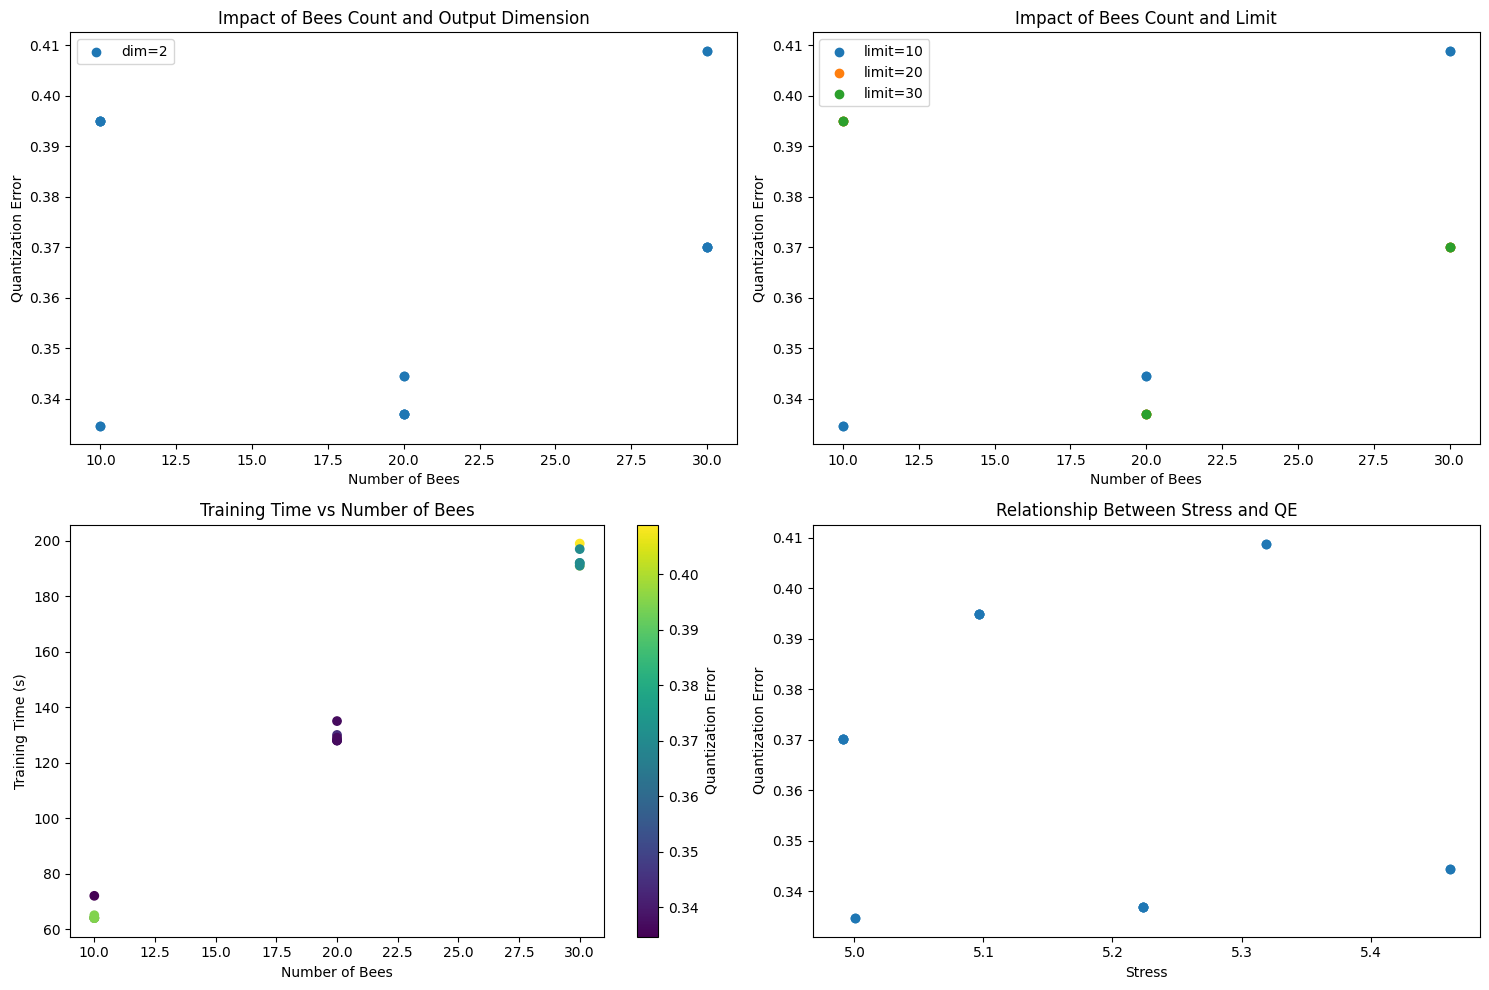

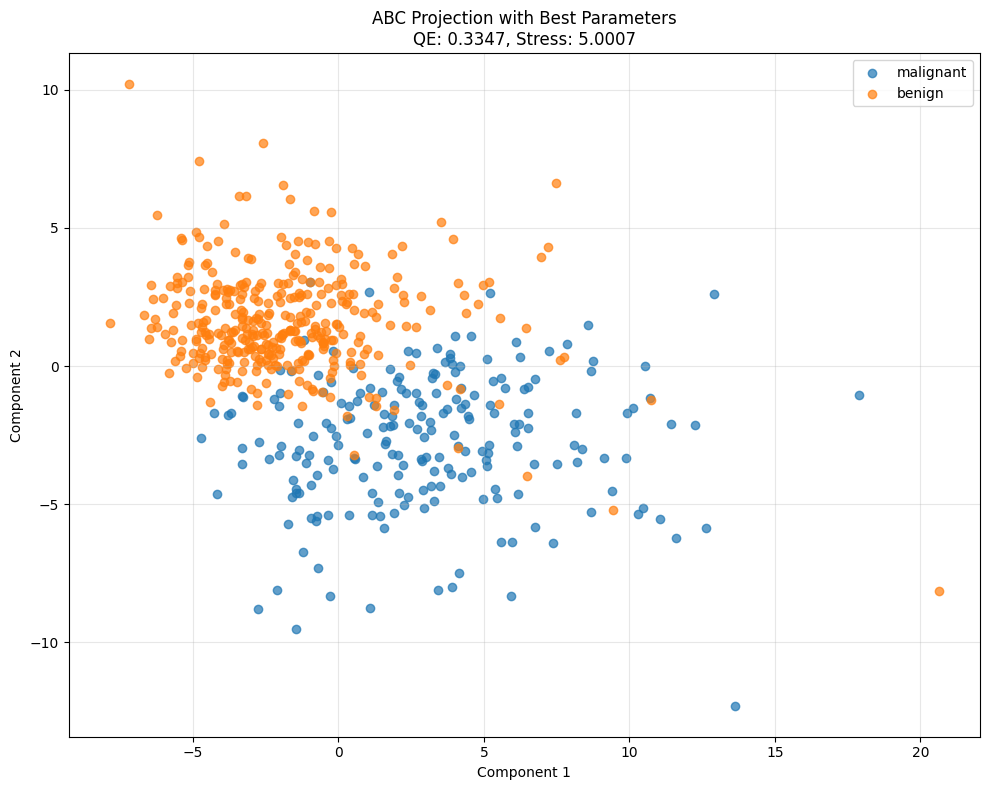


Recommended ABC parameters for breast cancer dataset:
  - output_dim: 2
  - n_bees: 10
  - limit: 10
  - max_cycles: 50
  - Expected QE: 0.3347
  - Expected stress: 5.0007
  - Approx. training time: 72.00 seconds


In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import your ABC algorithm
from algorithms.artificial_bee_colony import ArtificialBeeColony

# Load breast cancer dataset
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set random seed for reproducibility
np.random.seed(42)

# Define parameter grid
param_grid = {
    'output_dim': [2],
    'n_bees': [10, 20, 30],
    'limit': [10, 20, 30],
    'max_cycles': [50, 100]
}

# Create all parameter combinations
param_combinations = list(ParameterGrid(param_grid))
print(f"Total number of parameter combinations: {len(param_combinations)}")

# Function to evaluate an ABC model with specific parameters
def evaluate_abc(params, data, epochs=30, random_seed=42):
    # Initialize model with parameters
    model = ArtificialBeeColony(
        output_dim=params['output_dim'],
        n_bees=params['n_bees'],
        limit=params['limit'],
        max_cycles=params['max_cycles'],
        random_seed=random_seed
    )

    # Train model
    start_time = np.datetime64('now')
    model.train(data, epochs)
    end_time = np.datetime64('now')
    training_time = (end_time - start_time) / np.timedelta64(1, 's')

    # Calculate error metrics
    qe = model.quantization_error(data)

    # Calculate optional metrics
    # For example, you could add silhouette score, trustworthiness, etc.

    return {
        'quantization_error': qe,
        'training_time': training_time,
        'stress': model.best_fitness,
        'model': model
    }

# Run grid search
results = []

print("Running parameter grid search...")
for params in tqdm(param_combinations):
    result = evaluate_abc(params, X_scaled)
    results.append({
        **params,
        'quantization_error': result['quantization_error'],
        'training_time': result['training_time'],
        'stress': result['stress']
    })

    # Keep track of the best model separately
    if len(results) == 1 or result['quantization_error'] < best_result['quantization_error']:
        best_result = result.copy()
        best_params = params.copy()
        best_model = result['model']

# Convert results to DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Display sorted results
print("\nResults sorted by quantization error:")
print(results_df.sort_values('quantization_error').head(10))

print("\nResults sorted by stress:")
print(results_df.sort_values('stress').head(10))

print("\nBest parameters based on quantization error:")
print(best_params)

# Visualize parameter impact
plt.figure(figsize=(15, 10))

# 1. Output Dimension vs Error
plt.subplot(2, 2, 1)
for dim in param_grid['output_dim']:
    subset = results_df[results_df['output_dim'] == dim]
    plt.scatter(subset['n_bees'], subset['quantization_error'], label=f'dim={dim}')
plt.xlabel('Number of Bees')
plt.ylabel('Quantization Error')
plt.title('Impact of Bees Count and Output Dimension')
plt.legend()

# 2. Limit vs Error
plt.subplot(2, 2, 2)
for limit in param_grid['limit']:
    subset = results_df[results_df['limit'] == limit]
    plt.scatter(subset['n_bees'], subset['quantization_error'], label=f'limit={limit}')
plt.xlabel('Number of Bees')
plt.ylabel('Quantization Error')
plt.title('Impact of Bees Count and Limit')
plt.legend()

# 3. Training Time Analysis
plt.subplot(2, 2, 3)
plt.scatter(results_df['n_bees'], results_df['training_time'], c=results_df['quantization_error'], cmap='viridis')
plt.colorbar(label='Quantization Error')
plt.xlabel('Number of Bees')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Bees')

# 4. Stress vs QE
plt.subplot(2, 2, 4)
plt.scatter(results_df['stress'], results_df['quantization_error'])
plt.xlabel('Stress')
plt.ylabel('Quantization Error')
plt.title('Relationship Between Stress and QE')

plt.tight_layout()
plt.savefig('abc_parameter_tuning.png')
plt.show()

# Visualize the best model's projection
plt.figure(figsize=(10, 8))

# Project with best model and plot
projected_data = best_model.projected_data

# Plot different classes with different colors
for target_class in np.unique(y):
    class_indices = np.where(y == target_class)[0]
    plt.scatter(
        projected_data[class_indices, 0],
        projected_data[class_indices, 1],
        label=breast_cancer.target_names[target_class],
        alpha=0.7
    )

plt.title(f"ABC Projection with Best Parameters\nQE: {best_result['quantization_error']:.4f}, Stress: {best_result['stress']:.4f}")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('abc_best_projection.png')
plt.show()

# Save the results to CSV
results_df.to_csv('abc_parameter_tuning_results.csv', index=False)

# Print final recommendations
print("\nRecommended ABC parameters for breast cancer dataset:")
print(f"  - output_dim: {best_params['output_dim']}")
print(f"  - n_bees: {best_params['n_bees']}")
print(f"  - limit: {best_params['limit']}")
print(f"  - max_cycles: {best_params['max_cycles']}")
print(f"  - Expected QE: {best_result['quantization_error']:.4f}")
print(f"  - Expected stress: {best_result['stress']:.4f}")
print(f"  - Approx. training time: {best_result['training_time']:.2f} seconds")

# New Section